In [111]:
import numpy as np
import math
from spatialmath import SE3
from spatialmath.base import e2h,h2e
from roboticstoolbox import *
from machinevisiontoolbox import CentralCamera #针孔相机模型
%matplotlib widget

In [112]:
cam = CentralCamera(f=[913.08825216e-6,917.24582554e-6],rho = 1e-6, imagesize=[640,480], pp=[327.50021778,228.7678789])
print(cam)

           Name: perspective [CentralCamera]
     pixel size: 1e-06 x 1e-06
     image size: 640 x 480
           pose: t = 0, 0, 0; rpy/yxz = 0°, 0°, 0°
   principal pt: [327.50021778 228.7678789 ]
   focal length: [0.00091309 0.00091725]



In [113]:
P = np.array([-0.18,0,-0.01])

In [114]:
#相机DH
DFbot1 = DHRobot(
    [
        RevoluteMDH(d=0.04145,qlim=np.array([-np.pi,np.pi])),
        RevoluteMDH(alpha=np.pi/2,qlim=np.array([-np.pi,np.pi])),
        RevoluteMDH(a=-0.08285,qlim=np.array([-np.pi,np.pi])),
        RevoluteMDH(a=-0.08285,qlim=np.array([-np.pi,np.pi])),
        RevoluteMDH(alpha=-np.pi/2,qlim=np.array([0,np.pi])),
        RevoluteMDH(a=0.04,d=0.05,qlim=np.array([-np.pi,np.pi]))
    ],
    name = "DFbot",
)

#夹爪DH
DFbot2 = DHRobot(
    [
        RevoluteDH(d=0.04145,alpha=np.pi/2,qlim=np.array([-np.pi,np.pi])),
        RevoluteDH(a=-0.08285,qlim=np.array([-np.pi,np.pi])),
        RevoluteDH(a=-0.08285,qlim=np.array([-np.pi,np.pi])),
        RevoluteDH(alpha=-np.pi/2,qlim=np.array([-np.pi,np.pi])),
        RevoluteDH(d=0.11,qlim=np.array([-np.pi,3/2*np.pi]))
    ],
    name = "DFbot",
)

In [115]:
#视觉矫正
T1 = DFbot1.fkine([0,-np.pi/3,np.pi/3,np.pi,0,0])
SE3(T1)
DFbot1.plot([0,-np.pi/3,np.pi/3,np.pi,0,0])

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'DFbot')

In [116]:
#单一点投影矫正
p = cam.project_point(P,pose = T1)
cam.plot_point(P,pose=T1)
print(p)

[[523.65148298]
 [228.7678789 ]]


In [117]:
#立方体投影矫正
from machinevisiontoolbox import mkcube
X,Y,Z = mkcube(s=0.03,centre=(-0.165,0,-0.025),edge = True)
cam.plot_wireframe(X,Y,Z,pose=T1)

In [118]:
mtx = np.array([[913.08825216,   0.        , 327.50021778],
       [  0.        , 917.24582554, 228.7678789 ],
       [  0.        ,   0.        ,   1.        ]])

In [119]:
#求深度
K = mtx

pose = T1

extrinsic = np.linalg.inv(pose)

point_3d = np.array([-0.165,0,-0.01,1])

point_camera = extrinsic@point_3d

point_2d = K@point_camera[:3]
depth = point_2d[2]
point_2d/=depth

print(depth)
print(point_2d)

0.07320020470354073
[336.54375783 228.7678789    1.        ]


In [120]:
xaxis = 238
yaxis = 319
point_2d = depth*np.array([xaxis,yaxis,1])
point_camera = e2h(np.linalg.inv(K)@point_2d)
new_point_3d = np.array(np.linalg.inv(extrinsic)@point_camera)
print(new_point_3d)

[[-0.15709997]
 [ 0.00720092]
 [-0.01      ]
 [ 1.        ]]


In [121]:
T1

  -1         0         0        -0.1643    
   0         1         0         0         
   0         0        -1         0.0632    
   0         0         0         1         


In [122]:
T21 = DFbot2.fkine([0,-np.pi/3,np.pi/3,np.pi,0])
T21

  -1         0         0        -0.1243    
   0         1         0         0         
   0         0        -1         0.0032    
   0         0         0         1         


In [123]:
T2 = np.array(T21)
T2[:,-1] = new_point_3d.flatten()
T2

array([[-1.00000000e+00, -7.49879891e-33, -1.22464680e-16,
        -1.57099971e-01],
       [ 7.49879891e-33,  1.00000000e+00, -1.22464680e-16,
         7.20091556e-03],
       [ 1.22464680e-16, -1.22464680e-16, -1.00000000e+00,
        -1.00000000e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [124]:
sol = DFbot2.ikine_LM(T2,q0 = [0,-np.pi/3,np.pi/3,np.pi,0],ilimit=500,slimit=500,joint_limits=True,tol=0.005)
sol.q*180/np.pi

array([ -3.06158268, -39.97897755,  40.83182379, 179.09945372,
        -3.05958847])

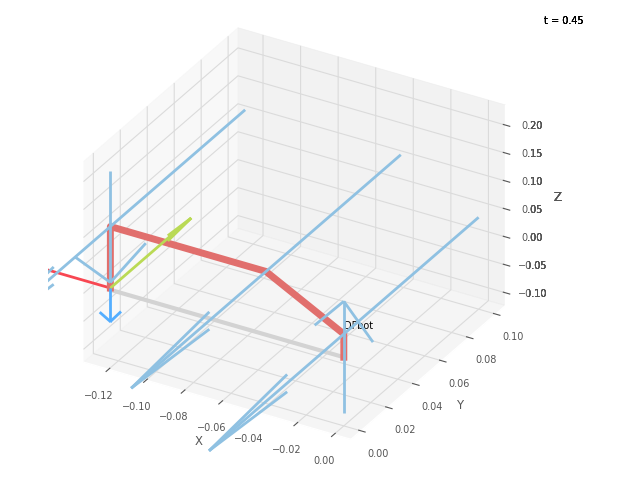

PyPlot3D backend, t = 0.49999999999999994, scene:
  robot: Text(0.0, 0.0, 'DFbot')

In [126]:
qt = jtraj([0,-np.pi/3,np.pi/3,np.pi,0],sol.q,10)
DFbot2.plot(qt.q,backend="pyplot")